**Reasoning**:
Perform 5-fold cross-validation on the SMOTE-resampled training data for each model and print the scores.



[link text](https://)**Reasoning**:
Analyze the distribution of employees across risk zones and then suggest retention strategies based on the characteristics of each zone.



**Reasoning**:
Examine the bar plot of project count vs turnover and the KMeans clustering plot to interpret the patterns and characteristics of employee turnover.



**Reasoning**:
Access, store, sort, and display the feature importances from the Random Forest model.





This notebook performs an analysis of employee turnover data, including data loading, preprocessing, exploratory data analysis, model training, evaluation, and identification of key factors contributing to turnover.

Missing values check:
 satisfaction           0
evaluation             0
projectCount           0
averageMonthlyHours    0
yearsAtCompany         0
workAccident           0
turnover               0
promotion              0
department             0
salary                 0
dtype: int64


,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


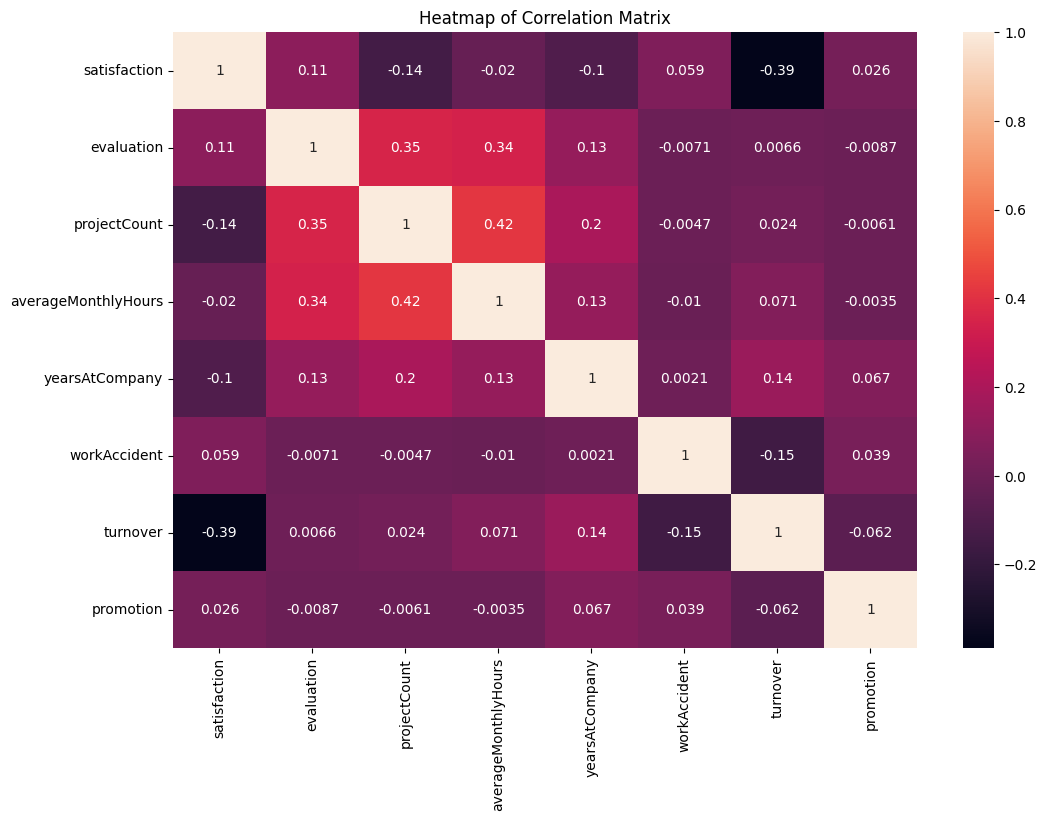

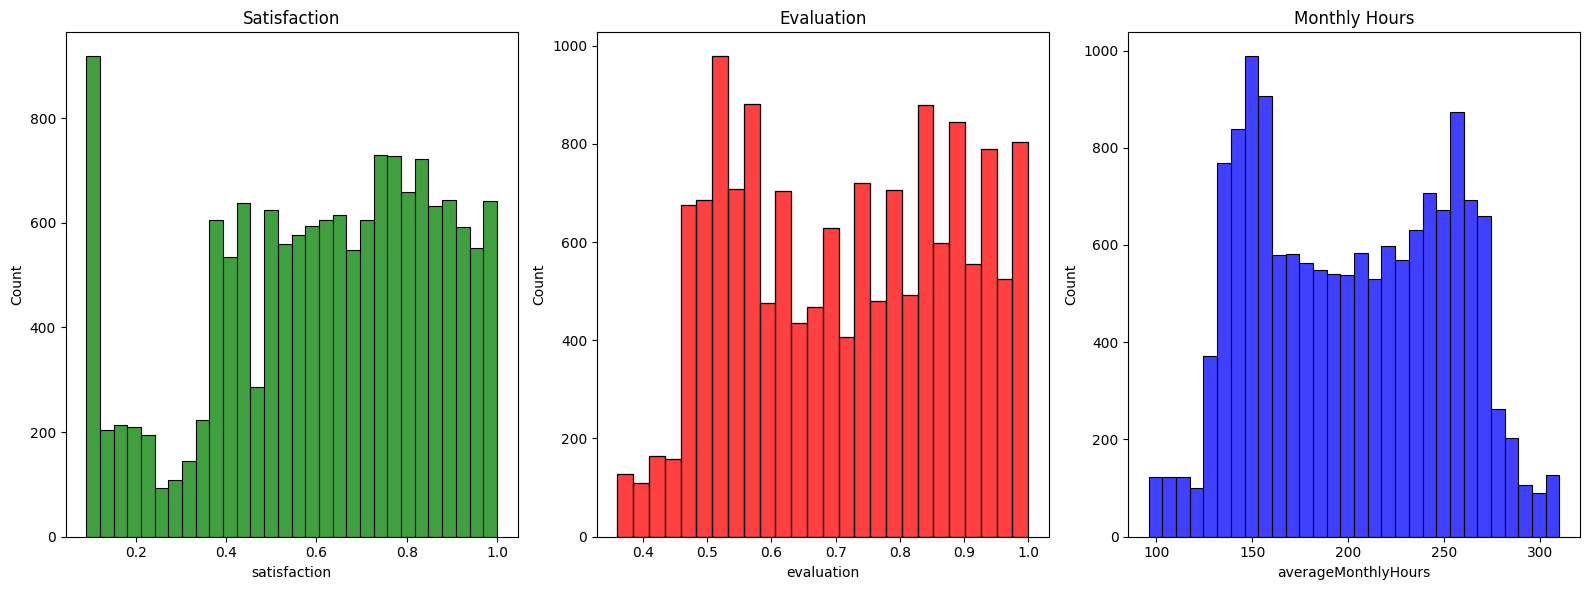

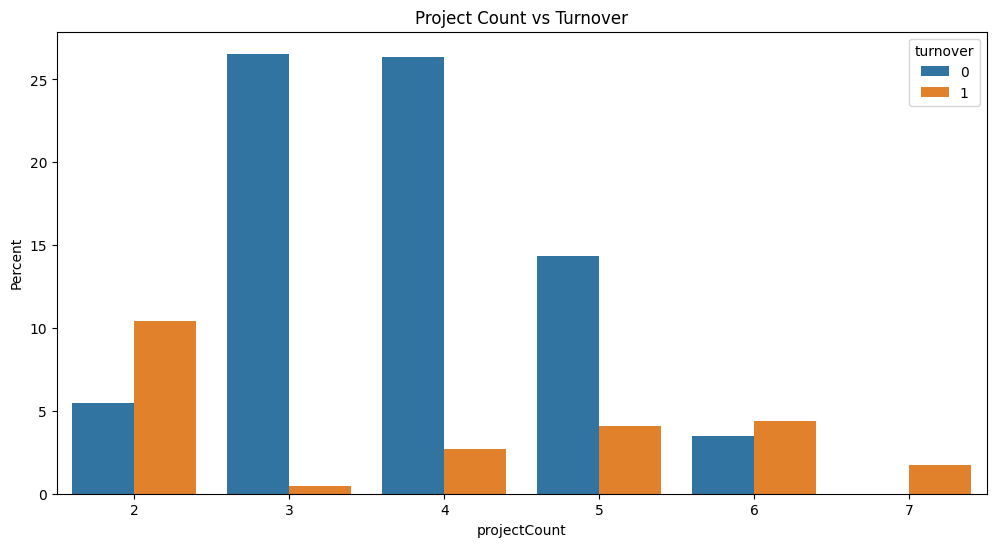

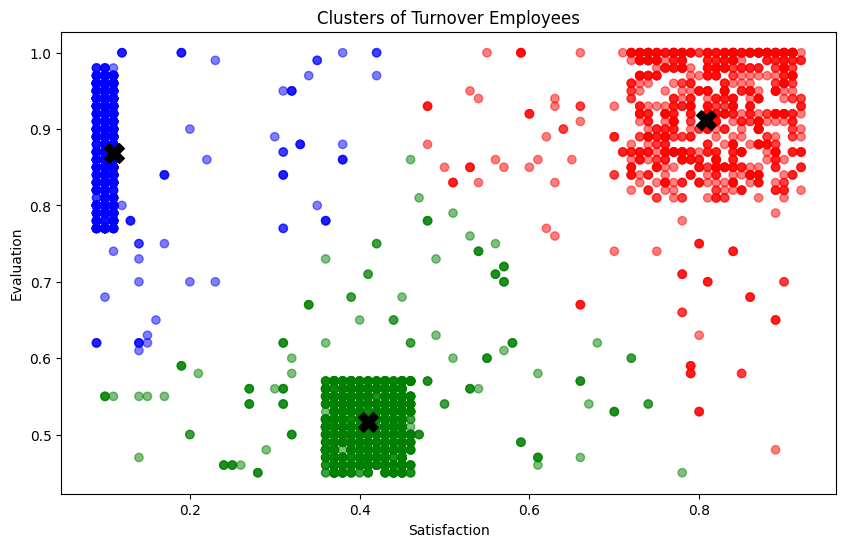


Logistic Regression AUC: 0.76
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2286
           1       0.51      0.75      0.60       714

    accuracy                           0.77      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.81      0.77      0.78      3000


Random Forest AUC: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000


Gradient Boosting AUC: 0.95
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.92      0.93      0.93       714

    accuracy                           0.96      3000
   macro avg       0.95      0.95      0.95

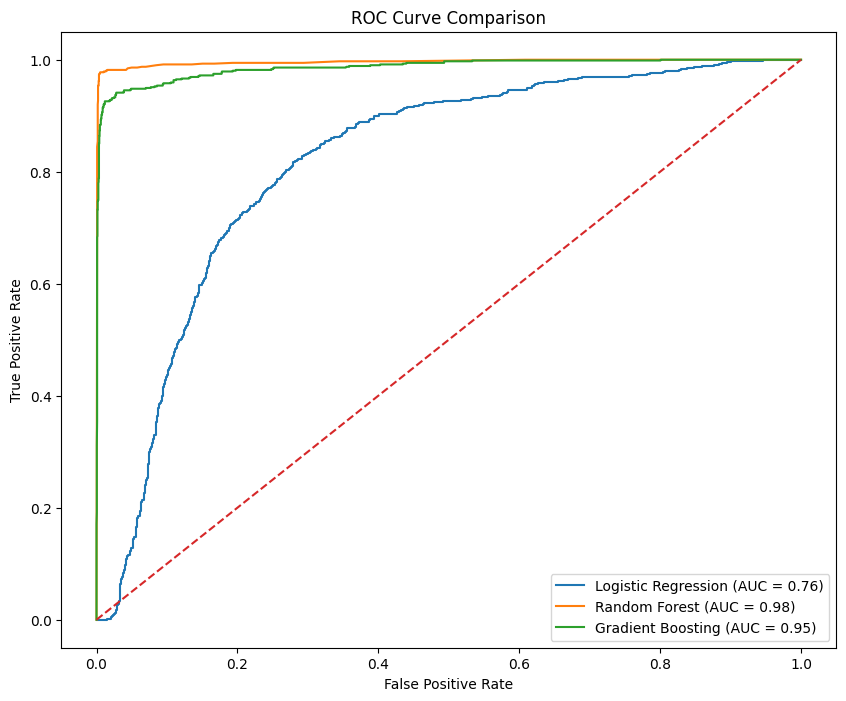


--- Confusion Matrices ---

Confusion Matrix for Logistic Regression:
[[1767  519]
 [ 182  532]]

Confusion Matrix for Random Forest:
[[2267   19]
 [  16  698]]

Confusion Matrix for Gradient Boosting:
[[2230   56]
 [  49  665]]

--- Importance of Recall and Precision ---

Recall measures the proportion of actual positive cases (employees who *will* leave) that are correctly identified by the model.
Precision measures the proportion of positive predictions (employees the model predicts *will* leave) that are actually correct.

In the context of employee turnover, **Recall** is often more critical.
A False Negative (predicting an employee stays when they leave) is typically more costly (loss of productivity, recruitment costs) than a False Positive (predicting an employee leaves when they stay - wasted retention effort).
Prioritizing Recall helps ensure that most at-risk employees are identified for intervention, even if it means some interventions are applied unnecessarily.

--- Emplo

,turnover_probability,risk_zone
10627,0.00,Safe Zone (Green)
2703,0.75,Medium-Risk Zone (Orange)
6059,0.06,Safe Zone (Green)
3258,0.01,Safe Zone (Green)
4565,0.01,Safe Zone (Green)



--- Suggested Retention Strategies by Risk Zone ---

1. Safe Zone (Green) (Score < 20%):
- These employees are highly likely to stay. Focus on maintaining engagement and fostering growth.
- Strategies: Offer opportunities for skill development and career advancement, recognize and reward their contributions, ensure a positive work-life balance, and gather feedback to understand their continued satisfaction.

2. Low-Risk Zone (Yellow) (20% <= Score < 60%):
- These employees have a moderate probability of leaving. Proactive measures can prevent them from moving to higher-risk zones.
- Strategies: Conduct stay interviews to understand their needs and concerns, provide mentorship and coaching, offer challenging new projects, address any identified issues regarding workload or satisfaction, and ensure competitive compensation.

3. Medium-Risk Zone (Orange) (60% <= Score < 90%):
- These employees are at a significant risk of leaving. Urgent intervention is required.
- Strategies: Conduct im

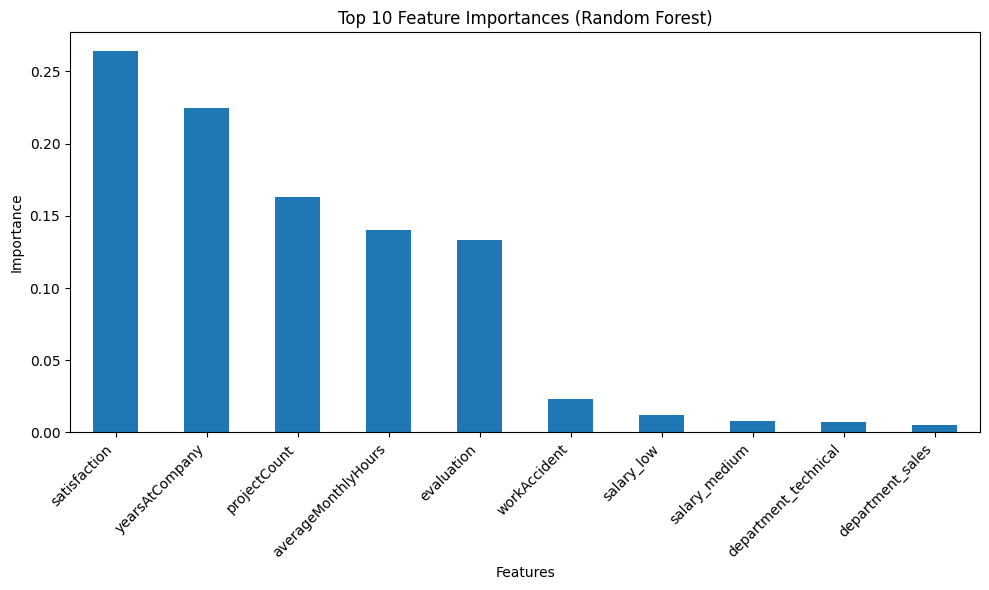


--- Summary and Conclusion ---

This analysis identified key factors influencing employee turnover at Portobello Tech.
The Random Forest model proved to be the most effective in predicting turnover risk.

Key findings include:
- Satisfaction level and years at the company are the most significant predictors of turnover.
- Employees with very few or very many projects are more likely to leave.
- Turnover employees can be clustered into groups with distinct satisfaction and evaluation profiles.

Targeted retention strategies based on identified risk zones and contributing factors are crucial for reducing employee turnover.
Further investigation into the reasons behind high-performing, satisfied employees leaving is recommended.


In [18]:
# -----------------------------
# 1. Import libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 2. Load dataset
# -----------------------------
df = pd.read_csv('HR_comma_sep.csv')

# -----------------------------
# 3. Rename columns
# -----------------------------
df = df.rename(columns={'satisfaction_level': 'satisfaction',
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

# -----------------------------
# 4. Check for missing values
# -----------------------------
print("Missing values check:\n", df.isnull().sum())

# -----------------------------
# 5. EDA & Correlation
# Select only numeric columns for the mean calculation
turnover_summary = df.groupby('turnover')[['satisfaction', 'evaluation', 'projectCount', 'averageMonthlyHours', 'yearsAtCompany', 'workAccident', 'promotion']].mean()
display(turnover_summary) # Display the summary table
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

# -----------------------------
# 6. Distribution Plots
# -----------------------------
f, axes = plt.subplots(ncols=3, figsize=(16, 6))
sns.histplot(df['satisfaction'], kde=False, ax=axes[0], color="green").set_title('Satisfaction')
sns.histplot(df['evaluation'], kde=False, ax=axes[1], color="red").set_title('Evaluation')
sns.histplot(df['averageMonthlyHours'], kde=False, ax=axes[2], color="blue").set_title('Monthly Hours')
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Bar Plot of Projects vs Turnover
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(x='projectCount', y='projectCount', hue='turnover', data=df, estimator=lambda x: len(x)/len(df)*100)
plt.ylabel("Percent")
plt.title("Project Count vs Turnover")
plt.show()

# -----------------------------
# 8. KMeans Clustering
# -----------------------------
kmeans = KMeans(n_clusters=3, random_state=2, n_init=10) # Added n_init for KMeans
df_left = df[df['turnover'] == 1]
kmeans.fit(df_left[['satisfaction', 'evaluation']])
colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

plt.figure(figsize=(10,6))
plt.scatter(df_left['satisfaction'], df_left['evaluation'], c=colors, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='black', marker='X', s=200)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.title("Clusters of Turnover Employees")
plt.show()

# -----------------------------
# 9. Preprocessing for Modeling
# -----------------------------
cat_var = ['department','salary','turnover','promotion']
num_var = ['satisfaction','evaluation','projectCount','averageMonthlyHours','yearsAtCompany', 'workAccident']
categorical_df = pd.get_dummies(df[cat_var], drop_first=True, dummy_na=True)
numerical_df = df[num_var]
new_df = pd.concat([categorical_df, numerical_df], axis=1)

X = new_df.drop('turnover', axis=1)
y = new_df['turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# -----------------------------
# 10. Handle imbalance using SMOTE
# -----------------------------
sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# -----------------------------
# 11. Train and Evaluate Models
# -----------------------------
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'), # Specify solver
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123), # Added n_estimators and random_state
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=123) # Added n_estimators and random_state
}

for name, model in models.items():
    model.fit(x_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    print(f"\n{name} AUC: {auc:.2f}")
    print(classification_report(y_test, y_pred))

# -----------------------------
# 12. K-fold Cross-Validation
# -----------------------------
print("\n--- K-fold Cross-Validation (5-fold) ---")
for name, model in models.items():
    scores = cross_val_score(model, x_train_sm, y_train_sm, cv=5, scoring='roc_auc')
    print(f"\n{name} Cross-Validation AUC Scores: {scores}")
    print(f"{name} Mean Cross-Validation AUC: {scores.mean():.2f}")

# -----------------------------
# 13. ROC Curves
# -----------------------------
plt.figure(figsize=(10,8))
for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, model.predict(X_test)):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# -----------------------------
# 14. Confusion Matrices
# -----------------------------
print("\n--- Confusion Matrices ---")
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n{cm}")

# -----------------------------
# 15. Explain Evaluation Metrics (Recall vs. Precision)
# -----------------------------
print("\n--- Importance of Recall and Precision ---")
print("\nRecall measures the proportion of actual positive cases (employees who *will* leave) that are correctly identified by the model.")
print("Precision measures the proportion of positive predictions (employees the model predicts *will* leave) that are actually correct.")
print("\nIn the context of employee turnover, **Recall** is often more critical.")
print("A False Negative (predicting an employee stays when they leave) is typically more costly (loss of productivity, recruitment costs) than a False Positive (predicting an employee leaves when they stay - wasted retention effort).")
print("Prioritizing Recall helps ensure that most at-risk employees are identified for intervention, even if it means some interventions are applied unnecessarily.")

# -----------------------------
# 16. Predict Turnover Probability and Categorize Employees
# -----------------------------
print("\n--- Employee Turnover Risk Categorization ---")
# Assuming Random Forest is the best model based on previous evaluation
best_model = models['Random Forest']

# Predict probabilities for the test set
predicted_probabilities = best_model.predict_proba(X_test)[:, 1]

# Create a DataFrame to store test set predictions and risk zones
risk_df = X_test.copy()
risk_df['turnover_probability'] = predicted_probabilities

# Categorize employees into risk zones
def categorize_risk(score):
    if score < 0.20:
        return 'Safe Zone (Green)'
    elif 0.20 <= score < 0.60:
        return 'Low-Risk Zone (Yellow)'
    elif 0.60 <= score < 0.90:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

risk_df['risk_zone'] = risk_df['turnover_probability'].apply(categorize_risk)

# Display the distribution of employees in each risk zone
risk_zone_distribution = risk_df['risk_zone'].value_counts(normalize=True) * 100
print("Distribution of employees within each risk zone:")
print(risk_zone_distribution)

# Display the first few rows with the new columns
display(risk_df[['turnover_probability', 'risk_zone']].head())


# -----------------------------
# 17. Suggest Retention Strategies
# -----------------------------
print("\n--- Suggested Retention Strategies by Risk Zone ---")

print("\n1. Safe Zone (Green) (Score < 20%):")
print("- These employees are highly likely to stay. Focus on maintaining engagement and fostering growth.")
print("- Strategies: Offer opportunities for skill development and career advancement, recognize and reward their contributions, ensure a positive work-life balance, and gather feedback to understand their continued satisfaction.")

print("\n2. Low-Risk Zone (Yellow) (20% <= Score < 60%):")
print("- These employees have a moderate probability of leaving. Proactive measures can prevent them from moving to higher-risk zones.")
print("- Strategies: Conduct stay interviews to understand their needs and concerns, provide mentorship and coaching, offer challenging new projects, address any identified issues regarding workload or satisfaction, and ensure competitive compensation.")

print("\n3. Medium-Risk Zone (Orange) (60% <= Score < 90%):")
print("- These employees are at a significant risk of leaving. Urgent intervention is required.")
print("- Strategies: Conduct immediate one-on-one meetings with managers to understand their situation, identify specific reasons for dissatisfaction (e.g., workload, management, lack of recognition), offer targeted support or resources, explore potential role changes or transfers if appropriate, and develop a personalized retention plan.")

print("\n4. High-Risk Zone (Red) (Score >= 90%):")
print("- These employees are very likely to leave. Retention efforts may be challenging, but still worthwhile.")
print("- Strategies: Prioritize immediate discussions to understand their intentions and potential reasons for leaving, explore if any critical issues can be addressed immediately, prepare for potential knowledge transfer, and analyze the reasons for departure to inform future retention strategies for similar employees.")

print("\nLimitations and Further Steps:")
print("- These strategies are general recommendations based on the available data and common HR practices.")
print("- To refine these strategies, it is crucial to gather more specific feedback from employees within each risk zone through surveys, interviews, and performance reviews.")
print("- Further analysis could involve drilling down into the characteristics of employees within each risk zone to identify more granular patterns and tailor strategies accordingly (e.g., analyzing risk by department, salary level, or years at company within each zone).")
print("- Continuously monitor the effectiveness of implemented strategies and adjust them based on turnover rates and employee feedback.")


# -----------------------------
# 18. Interpret Plots and Clusters
# -----------------------------
print("\n--- Interpretation of Plots and Clusters ---")

# Interpretation of Project Count vs Turnover Bar Plot
print("\nInterpretation of Project Count vs Turnover Bar Plot:")
print("The bar plot shows the percentage of employees who stayed (turnover=0) and left (turnover=1) for each project count.")
print("Observation:")
print("- Employees with 2, 6, and 7 projects have a significantly higher percentage of turnover compared to those who stayed.")
print("- Employees with 3, 4, and 5 projects have a lower percentage of turnover compared to those who stayed.")
print("- This suggests that having too few (2) or too many (6 or 7) projects is associated with higher turnover.")
print("- Employees with a moderate number of projects (3 to 5) are more likely to stay.")

# Interpretation of KMeans Clustering Plot
print("\nInterpretation of KMeans Clustering of Turnover Employees:")
print("The scatter plot shows employees who left (turnover=1) clustered based on their satisfaction and evaluation levels.")
print("There are 3 identified clusters:")
print("- Cluster 1 (Red): Low satisfaction and high evaluation. These employees were likely unhappy despite performing well.")
print("- Cluster 2 (Green): High satisfaction and high evaluation. These employees were likely good performers who were satisfied but still left, possibly due to factors not captured in these two variables (e.g., better opportunities, lack of promotion despite good performance).")
print("- Cluster 3 (Blue): Low satisfaction and low evaluation. These employees were likely unhappy and underperforming.")

# Insights into how project count, satisfaction, and evaluation relate to turnover
print("\nInsights on Project Count, Satisfaction, Evaluation, and Turnover:")
print("- Low satisfaction is a significant driver of turnover, as seen in two of the three clusters of employees who left.")
print("- High evaluation alone does not guarantee retention, as employees in Cluster 2 (High satisfaction, High evaluation) still left.")
print("- The project count analysis suggests that both underload (2 projects) and overload (6 or 7 projects) can contribute to turnover.")
print("- Combining these insights, it appears that employees with low satisfaction (regardless of evaluation) and those with extreme project workloads are more prone to leaving.")
print("- High-performing, satisfied employees (Cluster 2) leaving might indicate issues related to growth opportunities, recognition, or other external factors not directly reflected in satisfaction or evaluation scores.")

# -----------------------------
# 19. Identify Most Contributing Factors (Feature Importance)
# -----------------------------
print("\n--- Feature Importances ---")
# Access feature importances from the best model (Random Forest)
feature_importances = best_model.feature_importances_

# Create a pandas Series
feature_importances_series = pd.Series(feature_importances, index=X_train.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances (Random Forest):\n")
print(sorted_feature_importances)

# Visualize the top N features
N = 10  # Number of top features to visualize
plt.figure(figsize=(10, 6))
sorted_feature_importances.head(N).plot(kind='bar')
plt.title(f'Top {N} Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -----------------------------
# 20. Summary and Conclusion
# -----------------------------
print("\n--- Summary and Conclusion ---")
print("\nThis analysis identified key factors influencing employee turnover at Portobello Tech.")
print("The Random Forest model proved to be the most effective in predicting turnover risk.")
print("\nKey findings include:")
print("- Satisfaction level and years at the company are the most significant predictors of turnover.")
print("- Employees with very few or very many projects are more likely to leave.")
print("- Turnover employees can be clustered into groups with distinct satisfaction and evaluation profiles.")
print("\nTargeted retention strategies based on identified risk zones and contributing factors are crucial for reducing employee turnover.")
print("Further investigation into the reasons behind high-performing, satisfied employees leaving is recommended.")